# **Brooklyn Pizza Restaurant Analysis**

Joseph Lardie

December 2023

# **Imports**

In [1]:
#Numpy
import numpy as np

#Pandas
import pandas as pd

#Seaborn
import seaborn as sns

#matplotlib
import matplotlib.pyplot as plt
import plotly
%matplotlib inline

from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords

#Sklearn preprocessing
from sklearn import preprocessing,set_config
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,StandardScaler,LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer

#Scipy
from scipy import stats
from scipy.stats import norm

# Warnings
import warnings
warnings.filterwarnings("ignore")
set_config(display = 'diagram')

# **Import Data**

In [2]:
# Loading NYC Restaraunt Data
mdf = pd.read_csv('mdf')

In [3]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CAMIS                  506 non-null    int64  
 1   DBA                    506 non-null    object 
 2   BORO                   506 non-null    object 
 3   BUILDING               506 non-null    object 
 4   STREET                 506 non-null    object 
 5   ZIPCODE                502 non-null    float64
 6   CUISINE DESCRIPTION    506 non-null    object 
 7   INSPECTION DATE        506 non-null    object 
 8   ACTION                 506 non-null    object 
 9   VIOLATION CODE         504 non-null    object 
 10  VIOLATION DESCRIPTION  504 non-null    object 
 11  CRITICAL FLAG          506 non-null    object 
 12  SCORE                  506 non-null    float64
 13  GRADE                  506 non-null    object 
 14  GRADE DATE             499 non-null    object 
 15  INSPEC

# **Feature Engineering**

In [4]:
# Create a new column 'Restaurant Chain Indicator'
mdf['Chain Indicator'] = mdf['DBA'].duplicated(keep=False)

In [6]:
# Create a new column 'Full Address'
mdf['Full Address'] = mdf['BUILDING'] + ' ' + mdf['STREET']

In [7]:
# Define size categories
size_bins = [0, 50, 200, np.inf]
size_labels = ['Small', 'Medium', 'Large']

# Create 'Size Category' column
mdf['Size Category'] = pd.cut(mdf['review_count'], bins=size_bins, labels=size_labels)


In [9]:
# Filter the DataFrame to include only 'Pizza' restaurants
pizza_df = mdf[mdf['CUISINE DESCRIPTION'] == 'Pizza']

# Group by 'BORO' and calculate the average score for each group
avg_score_by_boro = pizza_df.groupby('BORO')['SCORE'].mean().reset_index()

# Display the DataFrame with the average score for pizza restaurants in each 'BORO'
print(avg_score_by_boro)

       BORO      SCORE
0  Brooklyn  16.766798


# **Visualizations**

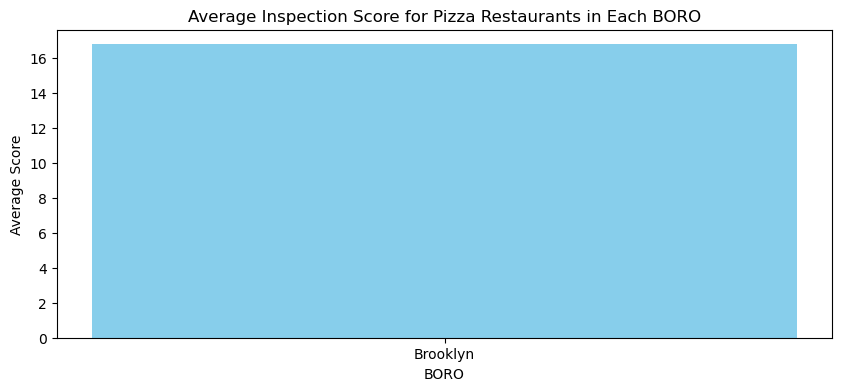

In [10]:
# Plotting the bar chart
plt.figure(figsize=(10, 4))
plt.bar(avg_score_by_boro['BORO'], avg_score_by_boro['SCORE'], color='skyblue')
plt.title('Average Inspection Score for Pizza Restaurants in Each BORO')
plt.xlabel('BORO')
plt.ylabel('Average Score')
plt.show()